# #402 Concrete Culvert - 3D Thick Shell
<i>Basic box culvert on spring foundations</i>
***

![Preview](../_img/jupyter_notebook_402.png)
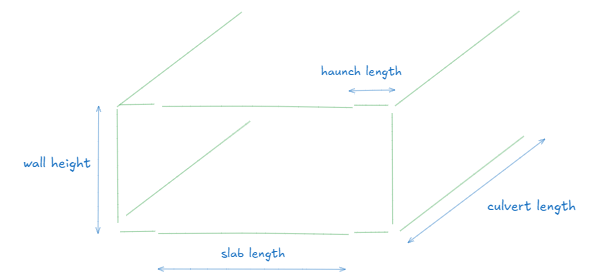

In [ ]:
wall_height = 2.5
wall_thk = 0.3
slab_length = 2.5
slab_thickness = 0.45
haunch_length = 1
haunch_thk = 0.65

culvert_length = 10

base_width = 1.4
base_thickness = 0.5
#cover = 0.05

mesh_size = 1

In [ ]:
import sys; sys.path.append('../') # Reference modules in parent directory
from shared.LPI_21_1 import *
lusas = get_lusas_modeller()

import shared.Helpers as Helpers
Helpers.initialise(lusas)

if lusas.existsDatabase() and lusas.db().isModified():
    raise Exception("This script will create a new model. Please save or close the current model and try again")

# Create a new model
lusas.newProject("Structural","Concrete Culvert")
# Get the database
db = lusas.database()
# 3D model with Z vertical
db.setAnalysisCategory("3D")
db.setVerticalDir("Z")
# Units
db.setModelUnits("kN,m,t,s,C")

lusas.view().setIsometric()



Create the attributes

In [ ]:
# # Beam mesh attributes
# beam_mesh_attr = db.createMeshLine("LMsh2").setSize("BMI21", mesh_size)
# # Beam geometric attribute
# beam_geom_attr = db.createGeometricLine("LGeo2").setFromLibrary("Australian Sections", "Precast Super T (Open)", "T3 (100)", 0, 0, 0)
# beam_geom_attr.setValue("elementType", "3D Thick Beam")
# beam_geom_attr.setEccentricityOrigin("Centroid", "Fibre", "", "A1")
# # Beam material attributes for short and long term
# beam_mat_attr = db.createIsotropicMaterial("Concrete beam", 34.8E6, 0.2, 2.4)
# beam_mat_attr_creep = db.createIsotropicMaterial("Concrete beam long term", 34.8E6/3, 0.2, 2.4)

# Shell mesh attribute, thick shell elements
shell_mesh_attr    = db.createMeshSurface("SMsh1").setRegularSize("QTS4", mesh_size, True)


# # Deck surface thickness attribute
# wall_surface_attr = db.createGeometricSurface("Walls").setSurface(wall_thickness, 0.0)
# slab_surface_attr = db.createGeometricSurface("Slab").setSurface(slab_thickness, 0.0)

# Concrete material attribute
concrete_mat_attr = db.createIsotropicMaterial("Concrete", 34.8E6, 0.2, 2.4, 12e-6)


# Support attributes
ground_spring_attr = db.createSupportStructural("Ground Spring").setStructural("F", "F", "S", "F", "F", "F", "F", "F", "C", "F") # F=Free, R=Restrained
ground_spring_attr.setSpring("Area", 0,0,200,0,0,0,0,0,0)

# support_slide_attr  = db.createSupportStructural("Slide").setStructural("F", "R", "R", "F", "F", "F", "F", "F", "C", "F")




In [ ]:
portal1_points = []
portal2_points = []


for y, points in [(0.0, portal1_points), (culvert_length, portal2_points)]:

    points.append( Helpers.create_point(0, y, 0) )
    points.append( Helpers.create_point(haunch_length, y, 0) )
    points.append( Helpers.create_point(haunch_length + slab_length, y, 0) )
    points.append( Helpers.create_point(haunch_length + slab_length + haunch_length, y, 0) )
    points.append( Helpers.create_point(haunch_length + slab_length + haunch_length, y, wall_height) )
    points.append( Helpers.create_point(haunch_length + slab_length, y, wall_height) )
    points.append( Helpers.create_point(haunch_length, y, wall_height) )
    points.append( Helpers.create_point(0, y, wall_height) )

portal1_lines = []
for i in range(len(portal1_points)-1):
    portal1_lines.append(Helpers.create_line_from_points(portal1_points[i], portal1_points[i+1]))
portal1_lines.append(Helpers.create_line_from_points(portal1_points[-1], portal1_points[0]))

portal2_lines = []
for i in range(len(portal2_points)-1):
    portal2_lines.append(Helpers.create_line_from_points(portal2_points[i], portal2_points[i+1]))
portal2_lines.append(Helpers.create_line_from_points(portal2_points[-1], portal2_points[0]))




In [ ]:
surfaces = []
geom_data = lusas.geometryData().setAllDefaults().setMaximumDimension(2)

for i in range(len(portal1_lines)):
    obs = lusas.newObjectSet()
    obs.add(portal1_lines[i]).add(portal2_lines[i])
    surfaces.append(obs.join(geom_data).getObject("Surface"))

shell_mesh_attr.assignTo(surfaces)

db.updateMesh()

In [ ]:
var_w2s_thk_attr = db.createVariationGrid("Wall to slab thickness").setGrid([[haunch_thk],[slab_thickness]], "Linear", "Constant")
var_s2w_thk_attr = db.createVariationGrid("Slab to wall thickness").setGrid([[slab_thickness],[haunch_thk]], "Linear", "Constant")
var_w2s_ecc_attr = db.createVariationGrid("Wall to slab eccentricity").setGrid([[(slab_thickness-haunch_thk)/2],[0]], "Linear", "Constant")
var_s2w_ecc_attr = db.createVariationGrid("Slab to wall eccentricity").setGrid([[0],[(slab_thickness-haunch_thk)/2]], "Linear", "Constant")

In [ ]:
geom_attr = []
geom_attr.append(db.createGeometricSurface("Bottom Haunch Left").setSurface(var_w2s_thk_attr, var_w2s_ecc_attr))
geom_attr.append(db.createGeometricSurface("Bottom Slab").setSurface(slab_thickness, 0))
geom_attr.append(db.createGeometricSurface("Bottom Haunch Right").setSurface(var_s2w_thk_attr, var_s2w_ecc_attr))
geom_attr.append(db.createGeometricSurface("Wall").setSurface(wall_thk, 0))
geom_attr.append(db.createGeometricSurface("Top Haunch Right").setSurface(var_w2s_thk_attr, var_w2s_ecc_attr))
geom_attr.append(db.createGeometricSurface("Top Slab").setSurface(slab_thickness, 0))
geom_attr.append(db.createGeometricSurface("Top Haunch Left").setSurface(var_s2w_thk_attr, var_s2w_ecc_attr))
geom_attr.append(db.createGeometricSurface("Wall").setSurface(wall_thk, 0))

for i in range(len(geom_attr)):
    geom_attr[i].assignTo(surfaces[i])

In [ ]:
concrete_mat_attr.assignTo(surfaces)

### Supports

In [ ]:
ground_spring_attr.assignTo(surfaces[:3])

### Search areas

In [ ]:
left_wall_search = db.createSearchArea("Left Wall")
right_wall_search = db.createSearchArea("Right Wall")

left_wall_search.assignTo(surfaces[-1])
right_wall_search.assignTo(surfaces[3])

# Loading

In [ ]:
# Gravity loadcase
gravity_loadcase = win32.CastTo(db.getLoadset(1), "IFLoadcase")
gravity_loadcase.setName("Self Weight")
gravity_loadcase.addGravity(True)

In [ ]:
earth_pressure_horiz_loadcase = db.createLoadcase("Earth Pressure Horizontal")



In [ ]:
horiz_ep_left_attr = db.createLoadingDiscretePatch("Horizontal Left Wall")
horiz_ep_left_attr.setDiscretePatch("surf4", "X")
horiz_ep_left_attr.addRow(0.0, 0.0, 0.0, 100.0)
horiz_ep_left_attr.addRow(0.0, culvert_length, 0.0, 100.0)
horiz_ep_left_attr.addRow(0.0, culvert_length, wall_height, 0.0)
horiz_ep_left_attr.addRow(0.0, 0.0, wall_height, 0.0)
horiz_ep_left_attr.setDivisions(0, 0)
assign = lusas.assignment().setAllDefaults().setLoadset(earth_pressure_horiz_loadcase).setSearchArea(left_wall_search)
horiz_ep_left_attr.assignTo(portal1_points[0], assign)


horiz_ep_right_attr = db.createLoadingDiscretePatch("Horizontal Right Wall")
horiz_ep_right_attr.setDiscretePatch("surf4", "X")
horiz_ep_right_attr.addRow(0.0, 0.0, 0.0, -100.0)
horiz_ep_right_attr.addRow(0.0, culvert_length, 0.0, -100.0)
horiz_ep_right_attr.addRow(0.0, culvert_length, wall_height, -0.0)
horiz_ep_right_attr.addRow(0.0, 0.0, wall_height, -0.0)
horiz_ep_right_attr.setDivisions(0, 0)
assign = lusas.assignment().setAllDefaults().setLoadset(earth_pressure_horiz_loadcase).setSearchArea(right_wall_search)
horiz_ep_right_attr.assignTo(portal1_points[3], assign)

In [ ]:
surcharge_loadcase = db.createLoadcase("Surcharge")
assign = lusas.assignment().setAllDefaults().setLoadset(surcharge_loadcase)

surcharge_left_attr = db.createLoadingLocalDistributed("Surcharge Left")
surcharge_left_attr.setLocalDistributed(0.0, 0.0, 10.0, "surface")
surcharge_right_attr = db.createLoadingLocalDistributed("Surcharge Right")
surcharge_right_attr.setLocalDistributed(0.0, 0.0, 10.0, "surface")

surcharge_left_attr.assignTo(surfaces[-1], assign)
surcharge_right_attr.assignTo(surfaces[3], assign)

In [ ]:
# hydrostatic_loadcase = db.createLoadcase("Water Flow")

Transformation Attributes

# Solve

In [ ]:
# db.getAnalysis("Analysis 1").solve(True)
# db.openAllResults()

In [ ]:
# lusas.view().insertContoursLayer()
# lusas.view().contours().setResultsTransformNone()
# lusas.view().contours().setResults("Force/Moment - Thick 3D Shell", "My")
# lusas.view().contours().setDisplayType("ElementNodal")